In [1]:
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# import local modules
sys.path.append('../src')
from Fishnet import Fishnet
from ImageExporter import ImageExporter
from ImageCorrector import ImageCorrector
from ImageProcessor import ImageProcessor

# update files automatically
%load_ext autoreload
%autoreload 2

## Install package within conda using tensorflow
## /opt/homebrew/Caskroom/miniconda/base/envs/capstone_2/bin/pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(42)

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import datetime

In [4]:
fc = Fishnet.load("../outputs/fishnet_quarter_mile_completed_2023-07-13.pkl")

In [5]:
# Compute Urbanization Rate
# for year in [2017, 2018, 2019, 2020, 2021, 2022]:
#     fc.compute_difference(f'MeanPixel_{year}', f'MeanPixel_{year-1}', filtered=True, normalize = True)

vars = ["id", "batch_id", "MeanPixel_2016", "MeanPixel_2017", "MeanPixel_2018", "MeanPixel_2019", "MeanPixel_2020", "MeanPixel_2021", "MeanPixel_2022"]
data = fc.filtered_fishnet[vars]
data.rename(columns={"id": "tile_id"}, inplace=True)
data["tile_id"] = data["tile_id"].astype(int)
data["batch_id"] = data["batch_id"].astype(int)

# Pivot wide to long
data = data.melt(id_vars=["tile_id", "batch_id"], var_name="year", value_name="urbanization")
data["urbanization"] = data["urbanization"] / 255 #normalization
data["year"] = data["year"].str[-4:]
data.head()

data.tre_csv('../Results/urbanization_bigMap.csv', index=False)

In [6]:
#compute rows and cols in Fishnet
dc = fc.filtered_fishnet.copy()
L = dc["geometry"].bounds["maxx"].max() - dc["geometry"].bounds["minx"].min()
H = dc["geometry"].bounds["maxy"].max() - dc["geometry"].bounds["miny"].min()

rows = int(H / fc.tile_height_degrees)
cols = int(L / fc.tile_width_degrees)
print(f"Number of rows: {rows}, Number of columns: {cols}")

Number of rows: 606, Number of columns: 1205


In [8]:
# Generate tensor
years = ["2016", "2017", "2018", "2019", "2020", "2021", "2022"]
tensor = np.zeros((len(years), rows, cols, 1))

for yr in tqdm(years):
    tensor[years.index(yr), :, :, 0] = data[data["year"]== yr]["urbanization"].to_numpy().reshape(rows, cols)

100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


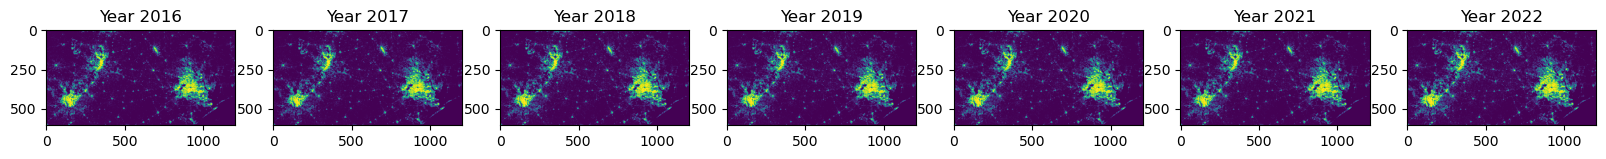

In [9]:
# plot consecutively to see the change
fig, ax = plt.subplots(1, 7, figsize=(20, 5))
for i in range(7):
    ax[i].imshow(tensor[i, :, :, 0])
    ax[i].set_title(f"Year {years[i]}")

In [11]:
tensor.shape

(7, 606, 1205, 1)

In [12]:
x = tensor[2:6, :, :, 0]
y = tensor[6, :, :, 0]

In [15]:
x.shape

(4, 606, 1205)

In [16]:
# mean of the last 4 years
y_pred_baseline = np.mean(x, axis=0)

In [18]:
# compute mse and r2 with scikitlearn
from sklearn.metrics import mean_squared_error, r2_score

mse_baseline = mean_squared_error(y, y_pred_baseline)
r2_baseline = r2_score(y, y_pred_baseline)

# print
print(f"Baseline MSE: {mse_baseline}")
print(f"Baseline R2: {r2_baseline}")

Baseline MSE: 0.002256389197452066
Baseline R2: 0.9393116497335869
